In [1]:
include("../ToolBox/ToolBox.jl")
import JLD
import FileIO
using .ToolBox
using .Geometry
using Colors

In [2]:
# Paths 
master_data_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_IW_SLC__1SDV_20190929T170932_20190929T170959_029239_035263_C3F9.SAFE/measurement/s1a-iw3-slc-vv-20190929t170934-20190929t170959-029239-035263-006.tiff"
master_meta_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_IW_SLC__1SDV_20190929T170932_20190929T170959_029239_035263_C3F9.SAFE/annotation/s1a-iw3-slc-vv-20190929t170934-20190929t170959-029239-035263-006.xml"
master_pod_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_OPER_AUX_POEORB_OPOD_20191019T120656_V20190928T225942_20190930T005942.EOF"

slave_data_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_IW_SLC__1SDV_20190917T170931_20190917T170958_029064_034C5E_2484.SAFE/measurement/s1a-iw3-slc-vv-20190917t170933-20190917t170958-029064-034c5e-006.tiff"
slave_meta_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_IW_SLC__1SDV_20190917T170931_20190917T170958_029064_034C5E_2484.SAFE/annotation/s1a-iw3-slc-vv-20190917t170933-20190917t170958-029064-034c5e-006.xml"
slave_pod_path = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_OPER_AUX_POEORB_OPOD_20191007T120623_V20190916T225942_20190918T005942.EOF"
#dem
dem_path = "/Users/simon/Data/DEM/denmark.jld";

In [3]:
master_view = [8000:10000,1200:6000]

2-element Array{UnitRange{Int64},1}:
 8000:10000
 1200:6000 

In [4]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
pad = 0.1
dem = JLD.load(dem_path);
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
dem[3][dem[3].<0] .= 0;

In [6]:
slave_data,flat,lut =  coregister_slave(master_view,slave_data_path,meta,precise_orbit,dem)
slave_data,mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[1]);
flat,mosaic_view = SlcUtil.mosaic(flat,master_view,meta[1]);

master_data = Load.slc_data(master_data_path,master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[1]);

In [7]:
kernel = ones(4,14)
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, slave_data, flat, kernel, mosaic_view);

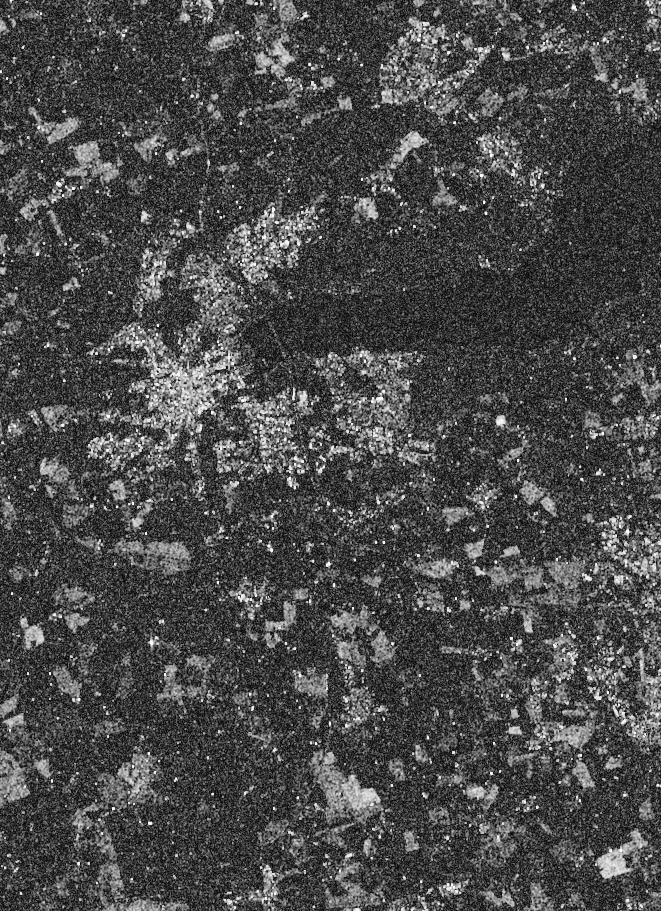

In [8]:
coherence_img = Gray.(abs.(complex_coherence[1:2:end,150:7:end]))

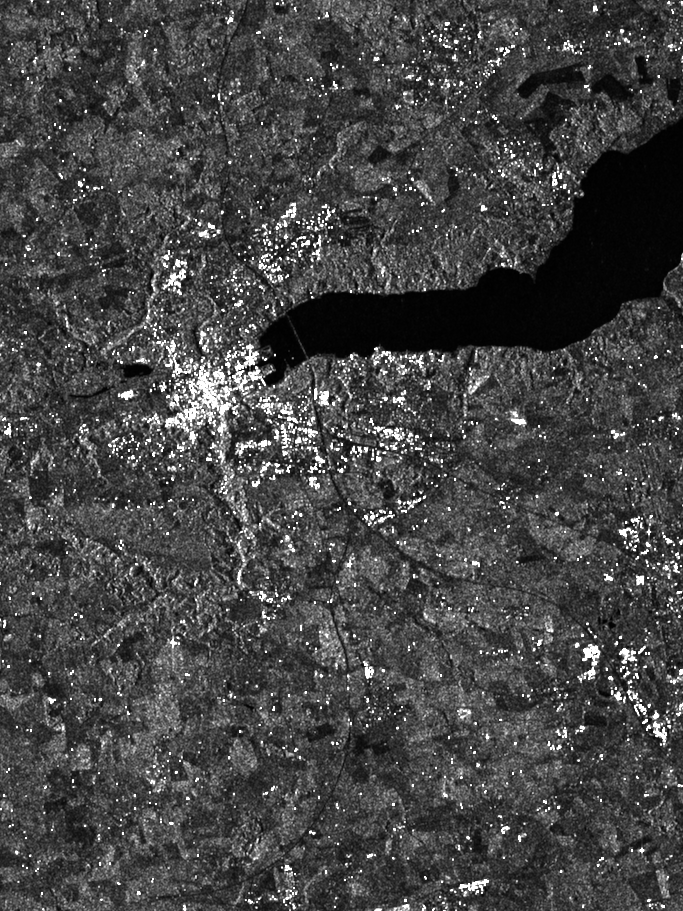

In [10]:
intensity = SlcUtil.show_img(master_intensity[1:2:end,1:7:end].-minimum(minimum(master_intensity[1:2:end,1:7:end])))

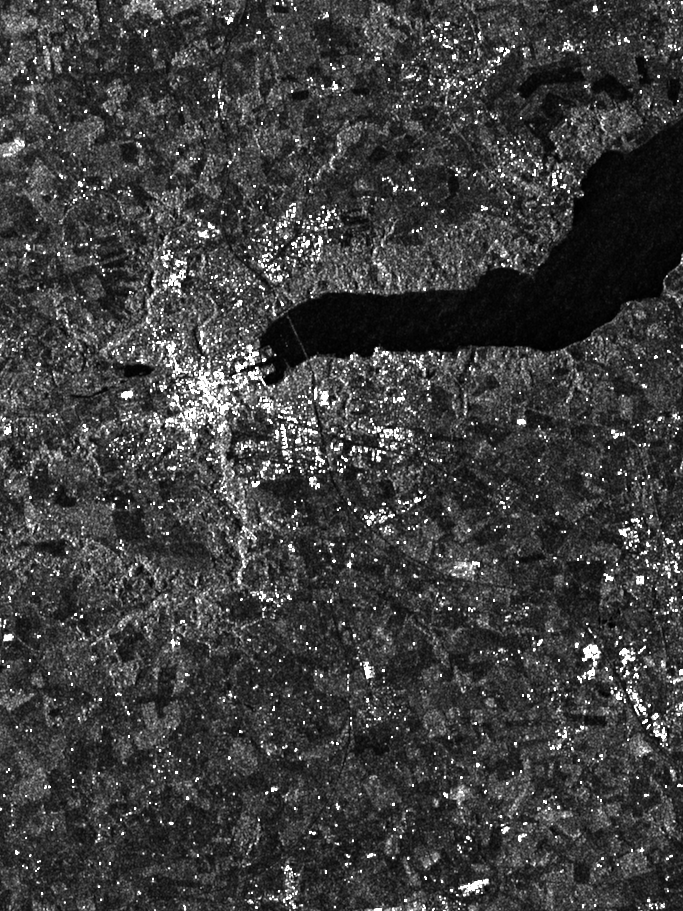

In [11]:
 SlcUtil.show_img(slave_intensity[1:2:end,1:7:end].-minimum(minimum(master_intensity[1:2:end,1:7:end])))

In [12]:
JLD.save("/Users/simon/Data/Sentinel/vejle_oktober/multilooked/pre_master_VV.jld", "data", master_intensity)
JLD.save("/Users/simon/Data/Sentinel/vejle_oktober/multilooked/pre_coherence_VV.jld", "data", complex_coherence)
JLD.save("/Users/simon/Data/Sentinel/vejle_oktober/multilooked/pre_slave_VV.jld", "data", slave_intensity)
JLD.save("/Users/simon/Data/Sentinel/vejle_oktober/multilooked/pre_line_sample.jld", "lines", lines, "samples", samples)